## Corn Disease Classification

The aim of this project is to buil models (specifically neural networks) that are able to classify images of corn leaves based on a specific disease.

The different diseases are:
- **Blight**: foliar disease of corn (maize) caused by a parasite. With its characteristic cigar-shaped lesions, this disease can cause significant yield loss in susceptible corn hybrids
- **Common Rust**: caused by the a fungus and occurs every growing season. It is seldom a concern in hybrid corn. Early symptoms of common rust are chlorotic flecks on the leaf surface
- **Gray Leaf Spot**: it is a foliar fungal disease that affects maize. GLS is considered one of the most significant yield-limiting diseases of corn worldwide. There are two fungal pathogens that cause GLS. Symptoms seen on corn include leaf lesions, discoloration (chlorosis), and foliar blight

After briefly discussing some tecnical aspects about biology let's jump into something more interesting for us.

We started with a folder, divided into subfolders, containing the different leaf images divided according to the disease. The first step was to build an actual dataset.

## Data Loading

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from PIL.ImageOps import crop, flip, mirror
import os
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
RANDOM_STATE = 42 # setting a constant random state for every methos that uses randomization

In [3]:
def create_data():
    name = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
    final_images = []
    final_labels = []

    for disease in name:
        folder_path = 'Corn Images/' + disease
        images = []
        labels = [disease] * len(os.listdir(folder_path))

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            images.append(img)

        final_images.extend(images)
        final_labels.extend(labels)

    return final_images, final_labels

In [4]:
result = create_data()
dataset = pd.DataFrame({'Image': result[0], 'Label': result[1]})

In [5]:
# a check to see if all the images have been loaded
print(dataset[dataset['Label'] == 'Blight'].count())
print(dataset[dataset['Label'] == 'Common_Rust'].count())
print(dataset[dataset['Label'] == 'Gray_Leaf_Spot'].count())
print(dataset[dataset['Label'] == 'Healthy'].count())

Image    1146
Label    1146
dtype: int64
Image    1306
Label    1306
dtype: int64
Image    574
Label    574
dtype: int64
Image    1162
Label    1162
dtype: int64


In [6]:
dataset.head(10)

,Image,Label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
5,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
6,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
7,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
8,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
9,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight


## Data Visualization

In [7]:
def show_image(image):
    image = image.copy()
    plt.imshow(image, aspect='equal')

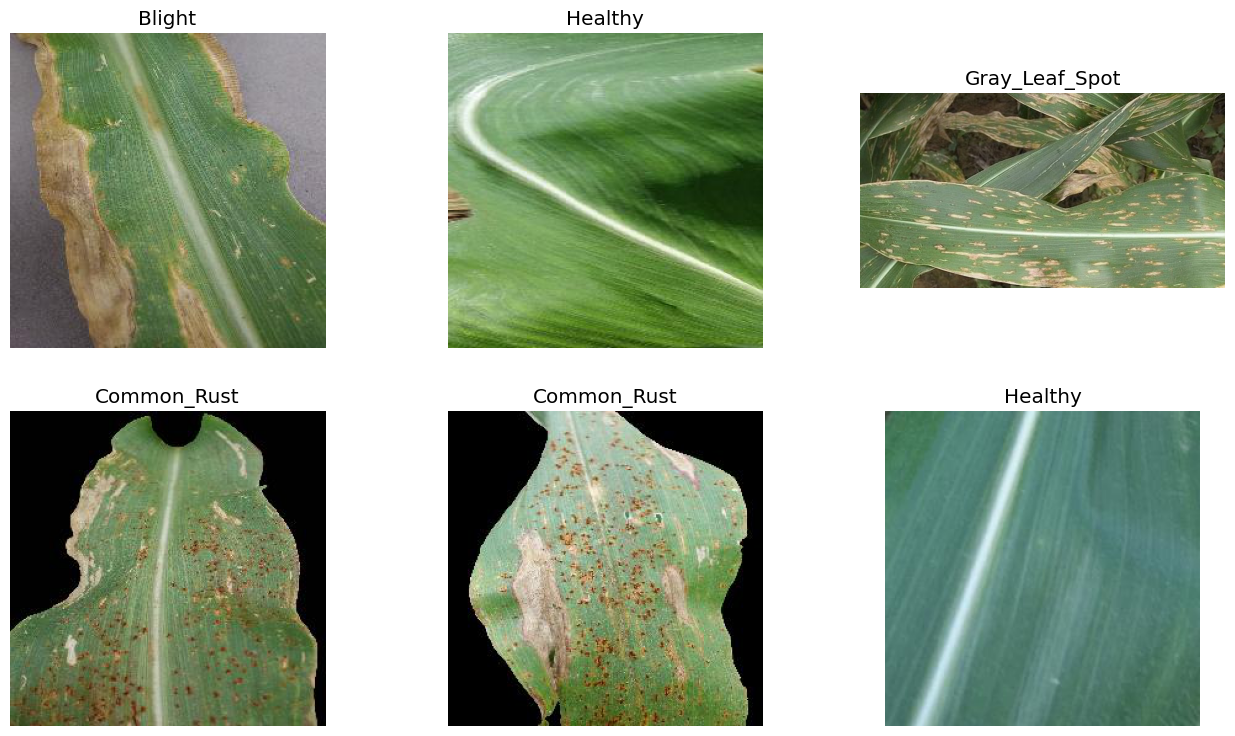

In [8]:
rng = np.random.default_rng(RANDOM_STATE)
n_cols = 3
n_rows = 2
indexes = rng.choice(len(dataset), n_cols * n_rows)

plt.figure(figsize=(16, 9))

for ii, id in enumerate(indexes, 1):
    plt.subplot(n_rows, n_cols, ii)
    image = dataset['Image'][int(id)]
    show_image(image)
    plt.title(dataset['Label'][int(id)])
    plt.axis('off')

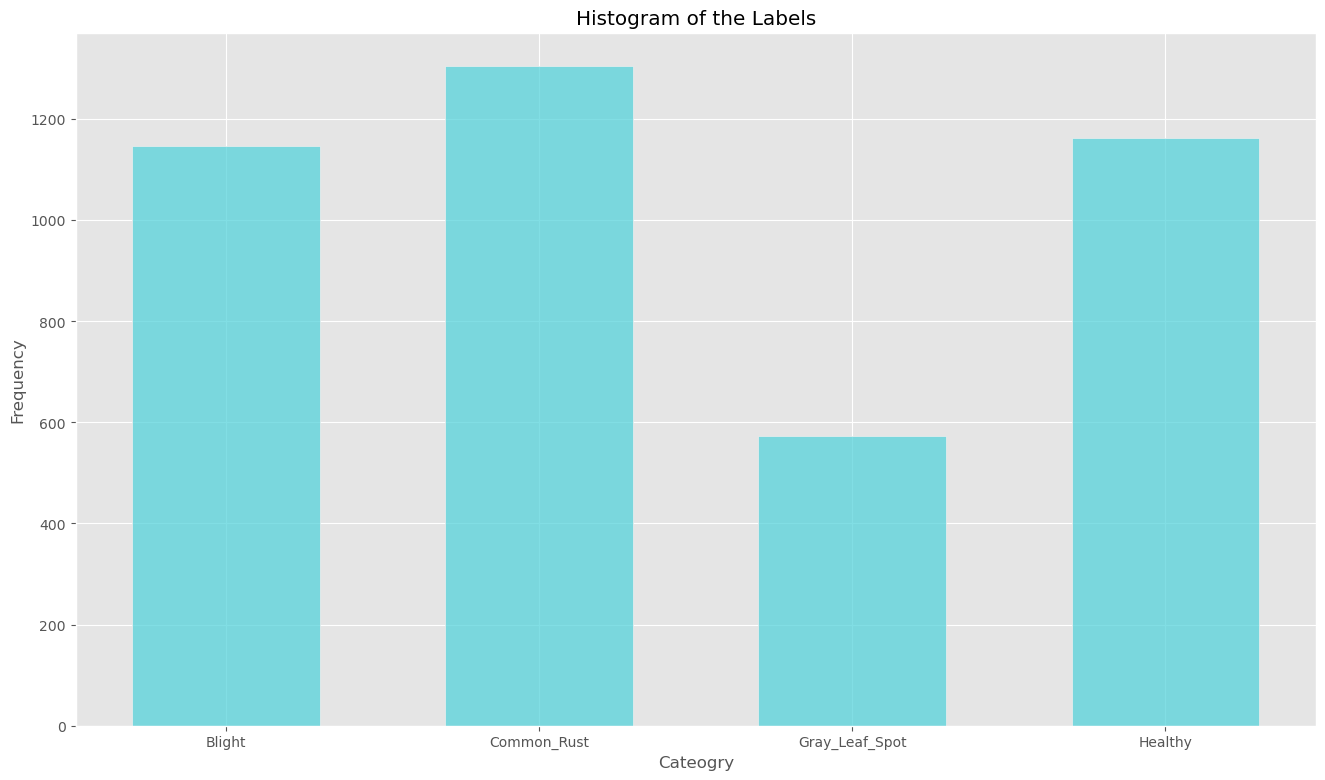

In [9]:
palette = sns.color_palette('hls', 4)

plt.figure(figsize=(16, 9))
sns.histplot(dataset['Label'], bins=4, shrink=0.6, kde=False, color=palette[2])

plt.xlabel('Cateogry')
plt.ylabel('Frequency')
plt.title('Histogram of the Labels')

# Show the plot
plt.show()

In [10]:
x = dataset[['Image', 'Label']] # using another variable to leave the original dataset intact

## Data Preparation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x['Image'], x['Label'], test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=x['Label'])

In [12]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (3350,)
X_test shape: (838,)
y_train shape: (3350,)
y_test shape: (838,)


In [13]:
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
y_train = y_train.values

In [14]:
enc = OneHotEncoder()

Y_train = enc.fit_transform(y_train[:, np.newaxis]).toarray()
Y_test = enc.transform(y_test[:, np.newaxis]).toarray()

## Data Augmentation

In [15]:
def Resize(content):
    return content.resize((224, 224))

In [16]:
def RandomRotation(content):
    p = 0.2
    if np.random.random() < p:
        return content.rotate(np.random.randint(-45, 45))
    else:
        return content

In [17]:
def RandomHorizontalFlip(content):
    p = 0.2
    if np.random.random() < p:
        return mirror(content)
    else:
        return content

In [18]:
def RandomVerticalFlip(content):
    p = 0.2
    if np.random.random() < p:
        return flip(content)
    else:
        return content

In [19]:
def RandomZoom(content):
    p = 0.2
    if np.random.random() < p:
        cropped = crop(content, np.random.randint(0, 50))
        return cropped.resize((224, 224))
    else:
        return content

In [20]:
def AdjustContrast(content):
    p = 0.2
    if np.random.random() < p:
        return ImageEnhance.Contrast(content).enhance(np.random.uniform(0.5, 1.5))
    else:
        return content

In [21]:
def AdjustBrightness(content):
    p = 0.2
    if np.random.random() < p:
        return ImageEnhance.Brightness(content).enhance(np.random.uniform(0.5, 1.5))
    else:
        return content

In [22]:
def DataAugmentation(content):
    content = RandomRotation(content)
    content = RandomHorizontalFlip(content)
    content = RandomVerticalFlip(content)
    content = RandomZoom(content)
    content = AdjustContrast(content)
    content = AdjustBrightness(content)
    return content

In [23]:
vectorized_function = np.vectorize(Resize, otypes=[object])
X_train = vectorized_function(X_train)
X_test = vectorized_function(X_test)

In [24]:
vectorized_function = np.vectorize(DataAugmentation, otypes=[object])
X_train = vectorized_function(X_train)

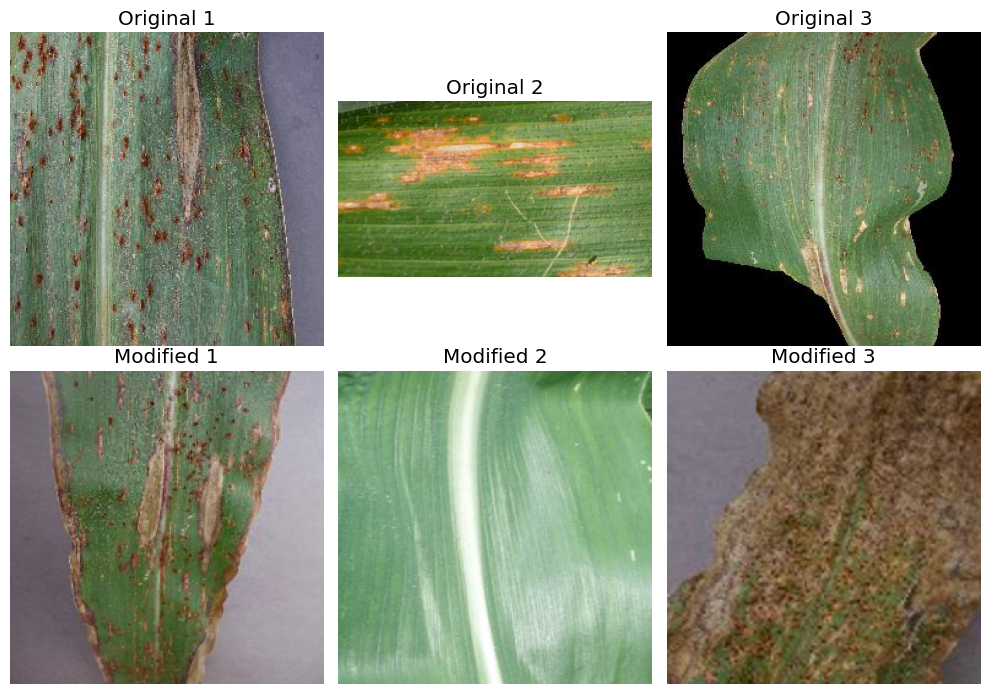

In [25]:
# Gli indici tra train e dataset originale sono diversi
rng = np.random.default_rng(RANDOM_STATE)
n_cols = 3
n_rows = 2
indexes = rng.choice(len(X_train), n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 7))

for i, ax in enumerate(axes[0]):
    original_image = x['Image'][int(indexes[i])]
    ax.imshow(original_image)
    ax.set_title(f'Original {i+1}')
    ax.axis('off')

for i, ax in enumerate(axes[1]):
    modified_image = X_train[indexes[i]]
    ax.imshow(modified_image)
    ax.set_title(f'Modified {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [27]:
def ToNumpy(content):
    return np.asarray(content, dtype=np.float32)

In [28]:
vectorized_function = np.vectorize(ToNumpy, otypes=[object])
X_train = vectorized_function(X_train)
X_test = vectorized_function(X_test)

In [29]:
def Rescale(content):
    return content / 255.0

In [30]:
vectorized_function = np.vectorize(Rescale, otypes=[object])
X_train = vectorized_function(X_train)
X_test = vectorized_function(X_test)

In [32]:
for i in range(len(X_train)):
    im = X_train[i]
    if im.shape != (224, 224, 3):
        print("Error, index =", i)
        print("Shape:", im.shape)

Error, index = 719
Shape: (224, 224, 4)
Error, index = 1548
Shape: (224, 224, 4)
Error, index = 1929
Shape: (224, 224, 4)


In [33]:
X_train = np.delete(X_train, [719, 1548, 1929])
y_train = np.delete(y_train, [719, 1548, 1929])

## Data Modelling

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input

from tensorflow.keras.utils import plot_model

In [35]:
input_shape = (224, 224, 3)

In [40]:
classifier = Sequential()

classifier.add(Input(shape=input_shape))

classifier.add(Conv2D(16, (3, 3), input_shape=input_shape, activation='relu', kernel_initializer='random_normal', strides=(1, 1), name = 'Conv2D_16'))
classifier.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPooling2D'))

classifier.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', kernel_initializer='random_normal', strides=(1, 1), name = 'Conv2D_32'))
classifier.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPooling2D1'))

classifier.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu', kernel_initializer='random_normal', strides=(1, 1), name = 'Conv2D_64'))
classifier.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPooling2D2'))

classifier.add(Conv2D(128, (3, 3), input_shape=input_shape, activation='relu', kernel_initializer='random_normal', strides=(1, 1), name = 'Conv2D_128'))
classifier.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPooling2D3'))

classifier.add(Dropout(0.5, name = 'Dropout'))

classifier.add(Flatten(name = 'Flatten'))

classifier.add(Dense(units=4, activation='softmax', kernel_initializer='random_normal', name = 'Dense-SoftMax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_16 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 MaxPooling2D (MaxPooling2D)  (None, 111, 111, 16)     0         
                                                                 
 Conv2D_32 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 MaxPooling2D1 (MaxPooling2D  (None, 54, 54, 32)       0         
 )                                                               
                                                                 
 Conv2D_64 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 MaxPooling2D2 (MaxPooling2D  (None, 26, 26, 64)       0         
 )                                                    

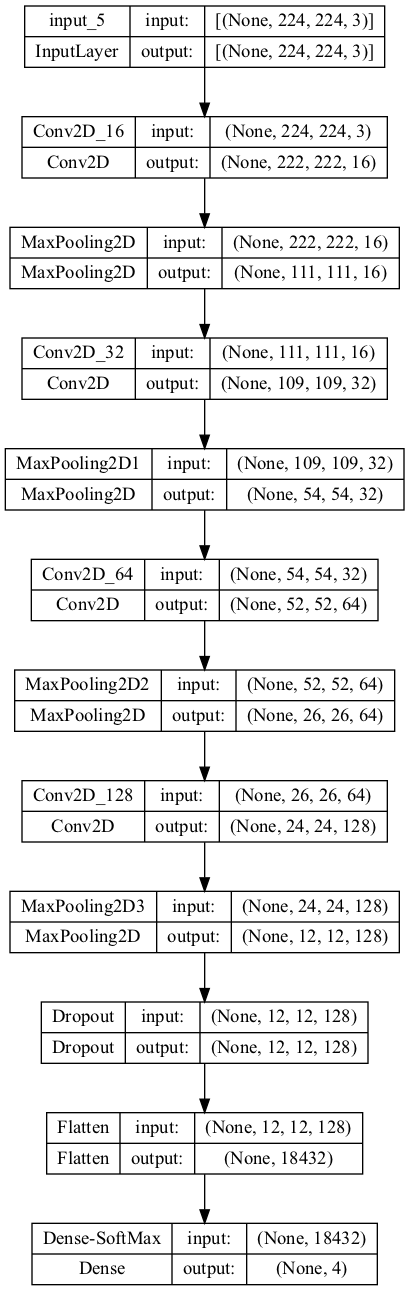

In [42]:
plot_model(classifier, to_file='CNN_ours.png', show_shapes=True, show_layer_names=True)

In [ ]:
# history = classifier.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)